In [13]:
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch

from torchvision.transforms import v2

torch.set_float32_matmul_precision('medium')

import kagglehub
import datasets # Why huggingface datasets if we using kagglehub dataset?!

In [2]:
dataset_path = kagglehub.dataset_download("hlrhegemony/pokemon-image-dataset")
dataset = datasets.load_dataset(dataset_path, split="train") # With two lines of code we have a datasets.Dataset with all data loaded =]

Resolving data files:   0%|          | 0/2503 [00:00<?, ?it/s]

In [14]:
transform_val = v2.Compose([
    v2.ToTensor(),
    v2.Resize((128, 128)),
    v2.Normalize((0.5,), (0.5,))
])

c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [11]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(128 * 16 * 16, 898), # poke_count = 898
)

model.load_state_dict(torch.load("poke_classifier.pth")) # Load the model weights from the file
model.eval() # Set the model to evaluation mode

C:\Users\setday\AppData\Local\Temp\ipykernel_19112\2258689243.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("poke_classifier.pth")) #

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=32768, out_features=898, bias=True)
)

In [15]:
def calculate_accuracy(model, dataset, transform):
    model.eval()
    
    acc = 0
    for entry in tqdm(dataset):
        image, label = entry["image"], entry["label"]
        image = transform(image).unsqueeze(0)
        pred = torch.argmax(model(image), dim=1)
        acc += (pred == label).item()
    return acc / len(dataset)

test_acc = calculate_accuracy(model, dataset, transform_val)

print(f"Test accuracy: {test_acc:.2f}")

100%|██████████| 2503/2503 [00:19<00:00, 127.87it/s]

Test accuracy: 0.91


100%|██████████| 16/16 [00:00<00:00, 150.43it/s]


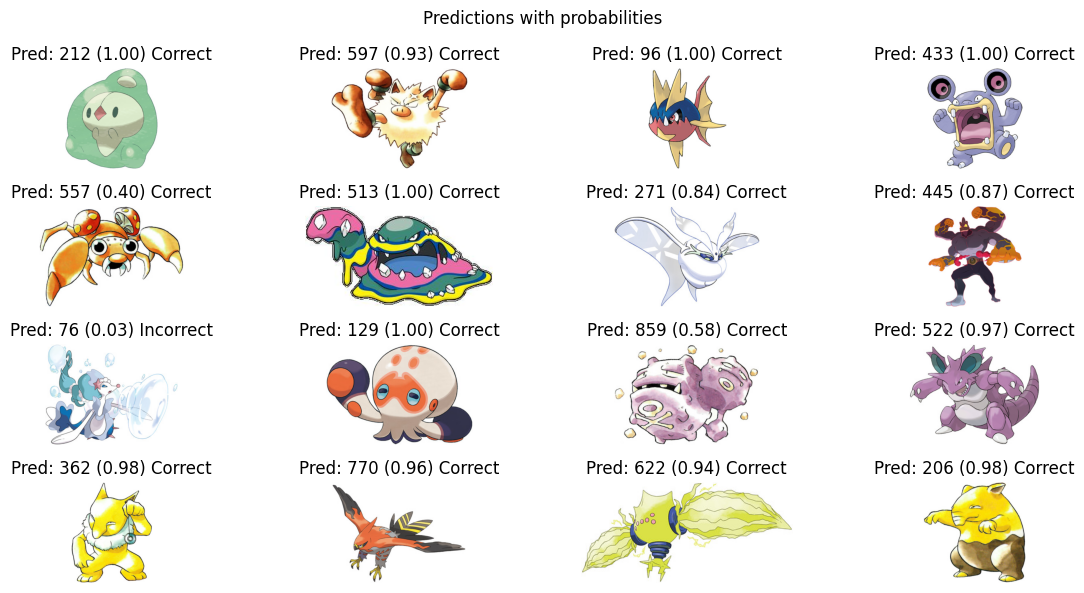

In [23]:
# visualise most accurate predictions
def show_most_and_less_accurate(model, dataset, transform, n=4, m=4):
    dataset = dataset.shuffle(seed=42)  # Shuffle the dataset for randomness
    dataset = dataset.select(range(n * m))  # Select the first n*m elements

    predicted_probs = []
    predictions = []
    
    for image, label in tqdm(zip(dataset["image"], dataset["label"]), total=len(dataset)):
        image = transform(image).unsqueeze(0)
        pred = model(image)

        probs = torch.softmax(pred, dim=1).squeeze(0)
        proba = probs[label].item()

        predictions.append(pred.argmax().item())
        predicted_probs.append(proba)

    fig, axes = plt.subplots(n, m, figsize=(12, 6))
    fig.suptitle("Predictions with probabilities")
    for i in range(n):
        for j in range(m):
            idx = i * m + j
            axes[i, j].imshow(dataset["image"][idx])
            axes[i, j].set_title(f"Pred: {predictions[idx]} ({predicted_probs[idx]:.2f}) {'Correct' if predictions[idx] == dataset['label'][idx] else 'Incorrect'}")
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

show_most_and_less_accurate(model, dataset, transform_val)

Как мы видим, модель весьма хорошо справляется с классфификацией покемонов, за исключением похожих особей (вполне возможно, что дальнейшее обучение или расширение количества представителей конкретного класса вполне могло бы исправить ситуацию, хотя этого и не особо требуется, ведь мы можем по малой уверенности отказывать в классификации).

Итог: в ходе выпоонения задания был решен целый список проблем, в которой входит:
- обучение на малопредставленных классах (невозможность адекватного деления на train/val/test)
- дизбаланс классов

Также стоит отметить, что качество можно улучших, расширив датасет и усложнив архитектуру.